## Examples of how to use the library pyVaRES

In [6]:
import matplotlib.pyplot as plt
from pyVaRES import *
import seaborn as sns
import pandas_datareader as web
sns.set()

In [7]:
# Import test data
testdata = pd.read_excel("Dataneeded/data_VAR.xlsx", index_col="Dates")
testret = testdata.pct_change().dropna()

#data for factorial
stocks = ["AAPL", "BAC", "JNJ", "VWAGY", "^GSPC", "^GDAXI"]
pf = web.DataReader(stocks, "yahoo", "2016-01-01", "2021-01-01")["Adj Close"]
retpf = pf.pct_change().dropna()

In [8]:
####### EXAMPLE 1: VaR_basic ############################
varG99 = VaR_basic(testret["SPY"], dist="gaussian")
varG99_rol = VaR_basic(testret["SPY"], dist="gaussian", rolling=True, start=100, win=500)
print("Gaussian 99% 1-day VaR for tomorrow: ", varG99)
print("-"*30)
print("Some values for rolling gaussian 99% 1-day VaR")
print(varG99_rol.tail(5))

Gaussian 99% 1-day VaR for tomorrow:  0.02795575074333259
------------------------------
Some values for rolling gaussian 99% 1-day VaR
Dates
2020-12-25    0.036099
2020-12-28    0.036108
2020-12-29    0.036074
2020-12-30    0.036075
2020-12-31    0.036071
Name: VaR, dtype: float64


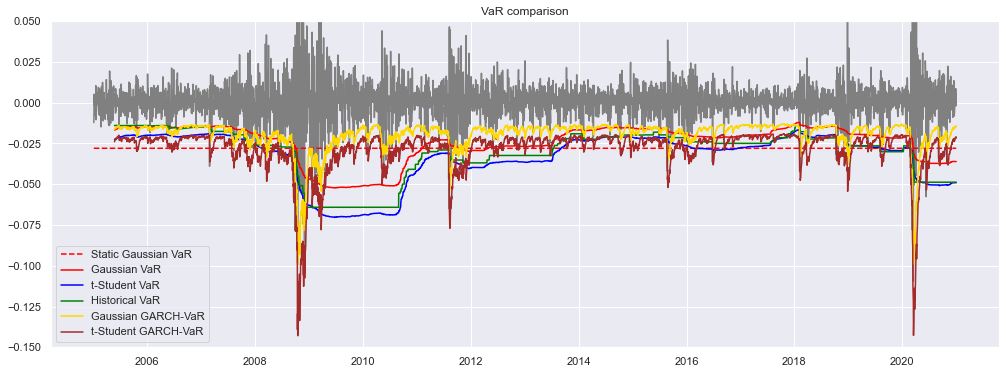

In [9]:
varT99_rol = VaR_basic(testret["SPY"], dist="tstudent", df=6, rolling=True, start=100, win=500)
varH99_rol = VaR_basic(testret["SPY"], dist="hist", rolling=True, start=100, win=500)
vargarchG99_rol = VaR_basic(testret["SPY"], dist="gaussian", rolling=True, start=100, garch=True)
vargarchT99_rol = VaR_basic(testret["SPY"], dist="tstudent", rolling=True, start=100, garch=True)
varG99 = np.full(len(testret), varG99)
df_varG99 = pd.DataFrame(varG99, index=testret.index)

# Plot VaR comparioson with associated SPY Etf returns
plt.figure(figsize=(17,6))
plt.plot(testret["SPY"], "grey")
# use - in VaR to plot it as a loss
plt.plot(-df_varG99, "red", linestyle="--", label="Static Gaussian VaR")
plt.plot(-varG99_rol, "red", label="Gaussian VaR")   # no VaR for first 100 days
plt.plot(-varT99_rol, "blue", label="t-Student VaR")
plt.plot(-varH99_rol, "green", label="Historical VaR")
plt.plot(-vargarchG99_rol, "gold", label="Gaussian GARCH-VaR")
plt.plot(-vargarchT99_rol, "brown", label="t-Student GARCH-VaR")
plt.ylim(-0.15, 0.05)
plt.title("VaR comparison")
plt.legend();

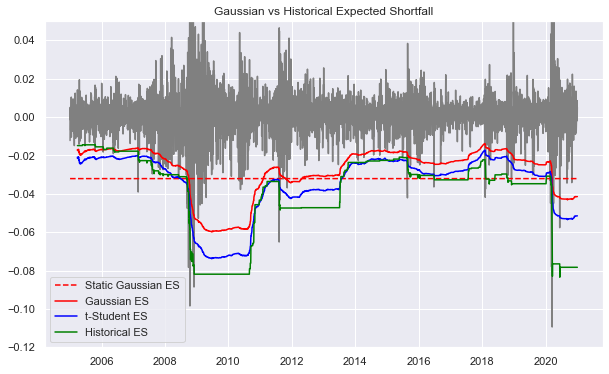

In [10]:
####### EXAMPLE 2: ES_basic ############################
esG99 = ES_basic(testret["SPY"], dist="gaussian")
esG99 = np.full(len(testret), esG99)
df_esG99 = pd.DataFrame(esG99, index=testret.index)
esG99_rol = ES_basic(testret["SPY"], dist="gaussian", rolling=True, start=60, win=500)
esT99_rol = ES_basic(testret["SPY"], dist="tstudent", df=7, rolling=True, start=60, win=500)
esH99_rol = ES_basic(testret["SPY"], dist="hist", rolling=True, start=60, win=500)

plt.figure(figsize=(10,6))
plt.plot(testret["SPY"], "grey")
plt.plot(-df_esG99, "red", linestyle="--", label="Static Gaussian ES")
plt.plot(-esG99_rol, "red", label="Gaussian ES")
plt.plot(-esT99_rol, "blue", label="t-Student ES")
plt.plot(-esH99_rol, "green", label="Historical ES")
plt.ylim(-0.12, 0.05)
plt.title("Gaussian vs Historical Expected Shortfall")
plt.legend();

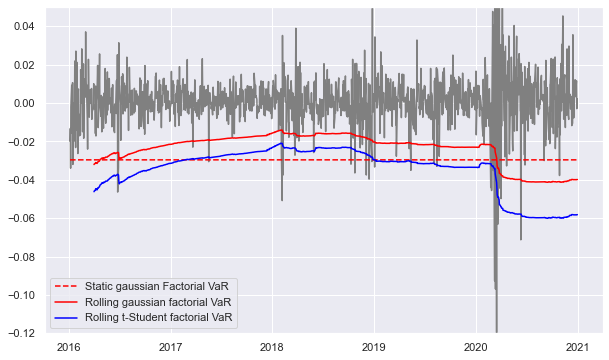

In [13]:
####### EXAMPLE 3: VaR Factorial ############################
VaR_f = pf_factVaRES(retpf[["AAPL", "BAC", "JNJ", "VWAGY"]],  # stocks in portfolio
                      retpf[["^GSPC", "^GDAXI"]],              # mapping factors
                      w = [1/4, 1/4, 1/4, 1/4])[0]                # weights of stock portfolio
VaR_f = np.full(len(retpf), VaR_f)  # create pd series as before
VaR_f = pd.Series(VaR_f, index=retpf.index, name="VaR")
# rolling
df1 = pf_factVaRES(r=retpf[["AAPL", "BAC", "JNJ", "VWAGY"]], fact=retpf[["^GSPC", "^GDAXI"]], w=[1/4, 1/4, 1/4, 1/4], dist="gaussian", rolling=True, start=60, win=500)[0]
df2 = pf_factVaRES(r=retpf[["AAPL", "BAC", "JNJ", "VWAGY"]], fact=retpf[["^GSPC", "^GDAXI"]], w=[1/4, 1/4, 1/4, 1/4], dist="tstudent", rolling=True, start=60, win=500)[0]
# portfolio returns
retpf["r"] = retpf["AAPL"]*1/4 + retpf["BAC"]*1/4 + retpf["JNJ"]*1/4 + retpf["VWAGY"]*1/4

plt.figure(figsize=(10,6))
plt.plot(retpf["r"], "grey")
plt.plot(-VaR_f, "red", linestyle="--", label="Static gaussian Factorial VaR")
plt.plot(-df1, "red", label="Rolling gaussian factorial VaR")
plt.plot(-df2, "blue", label="Rolling t-Student factorial VaR")
plt.ylim(-0.12, 0.05)
plt.legend();

In [14]:
####### EXAMPLE 4: VaR Validation ############################
vG99 = VaR_basic(testret["SPY"], dist="gaussian")
vG99 = np.full(len(testret), vG99)
varG99 = pd.Series(vG99, index=testret.index, name="VaR")
print(VaR_validation(testret["SPY"], varG99, print_output=True)) # Var series must be positive

-----------------------------------
Theoretical exceedances: 41.730000000000004
Realized exceedances: 80
--> Zscore =  5.9541
--> pvalue =  0.0
The VaR is NOT valid
-----------------------------------
(5.954107515141424, 2.6149486225261165e-09)
